In [697]:
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import swifter
import re
import string
from tqdm import tqdm

from multiprocessing import Pool
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
## The following data sources imported as denominated for data privacy issue

# Generate Data

In [ ]:
# use glob to get all the csv files in the folder
root ='\Valid dataset'
post = pd.DataFrame()
csv_files = glob.glob(os.path.join(root, "*.csv"))
print(len(csv_files))
for f in csv_files:
    # read the csv file
    df = pd.read_csv(f, lineterminator='\n')
    post = pd.concat([post, df])


In [845]:
post = pd.read_csv('caregiver_spouse_adrd_online_post.csv', index_col=0).reset_index(drop=True)

In [846]:
post = post.dropna(subset=['Relationship_toPersonwithDementia', 'content'])

In [847]:
post['content'] = post.content.swifter.apply(lambda x: x.replace(u'\xa0', u' ').replace('\n', ' ').replace('\t', ' ').replace('\r', ' '))

Pandas Apply:   0%|          | 0/533429 [00:00<?, ?it/s]

In [848]:
post['content_len'] = post.content.swifter.apply(lambda x: len(x.split()))

Pandas Apply:   0%|          | 0/533429 [00:00<?, ?it/s]

In [850]:
len(post)

508030

In [851]:
post['Relationship_toPersonwithDementia'].value_counts()

I am their partner or spouse     245105
I am their child                 205322
I have dementia                   20880
I am their relative               18240
I am a professional caregiver      5228
I am their grandchild              4045
Not Shared                         3924
I am their friend                  2696
I am their sibling                 2433
I am their neighbor                 157
Name: Relationship_toPersonwithDementia, dtype: int64

In [852]:
def relation_map(x):
    if x == 'I am their partner or spouse' or x == 'I am their child':
        return x
    else:
        return 'Other'

In [853]:
post['Relationship'] = post['Relationship_toPersonwithDementia'].swifter.apply(lambda x: relation_map(x))

Pandas Apply:   0%|          | 0/508030 [00:00<?, ?it/s]

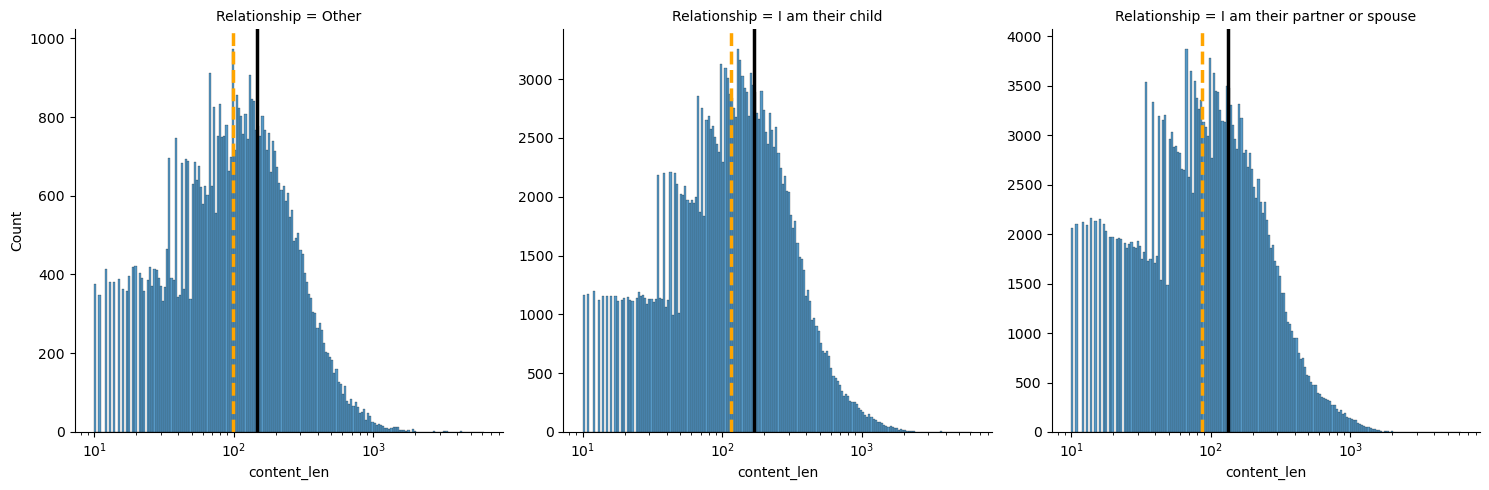

In [854]:
g = sns.displot(
    data=post, x='content_len',
    col='Relationship',  
    facet_kws=dict(sharey=False, sharex=False),
    log_scale=(10,False)
)

def specs(x, **kwargs):
    plt.axvline(x.mean(), c='k', ls='-', lw=2.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)

g.map(specs,'content_len')
plt.show()

In [855]:
post['Relationship'].value_counts()

I am their partner or spouse    245105
I am their child                205322
Other                            57603
Name: Relationship, dtype: int64

In [860]:
def relation_class(x):
    if x == 'I am their partner or spouse':
        return 0
    elif x == 'I am their child':
        return 1
    else:
        return 2

In [861]:
user['Relationship class'] = user.Relationship.swifter.apply(lambda x: relation_class(x))

Pandas Apply:   0%|          | 0/18412 [00:00<?, ?it/s]

In [262]:
post2user = dict(zip(post.post_id, post.user_id))
post2topic = dict(zip(post.post_id, post.topic_id))
post2content = dict(zip(post.post_id, post.content))

In [862]:
train_user, test_user = train_test_split(user, test_size=0.2, stratify=user['Relationship class'], random_state=19)

In [863]:
train_post = post[post.user_id.isin(train_user.user_id)].reset_index(drop=True)

In [864]:
test_post = post[post.user_id.isin(test_user.user_id)].reset_index(drop=True)

In [869]:
test_post_2class = test_post[test_post['Relationship'] != 'Other'].reset_index(drop=True)

In [871]:
test_post_2class[['user_id', 'content', 'join_date', 'post_date']].to_csv('./multi-task-NLP-master/adrd/data/all_test_post.tsv', sep='\t')

In [872]:
test_post_2class[['Relationship','content']].to_csv('./multi-task-NLP-master/adrd/data/userclass_test_all.tsv', sep='\t')

In [242]:
def get_sample_post(x):
    if len(x) <= 10:
        return x
    else:
        return x.sample(10, random_state=31)

In [370]:
current_post = train_post
NUM_SAMPLE = 53924
# current_post = test_post
# NUM_SAMPLE = 13631

In [371]:
user_post = current_post.groupby('user_id').apply(lambda x: get_sample_post(x.post_id).to_numpy()).rename('post_id').reset_index()

In [372]:
user_post['num_post'] = user_post.post_id.swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/14729 [00:00<?, ?it/s]

In [373]:
user_two_post = user_post[user_post['num_post'] > 1]

In [374]:
len(user_post), len(user_two_post)

(14729, 8823)

In [375]:
num_two_post = user_two_post.num_post.to_numpy()

In [376]:
num_two_post = num_two_post / np.linalg.norm(num_two_post, 1)

In [377]:
rng = np.random.default_rng( )
pos_post_pair = pd.DataFrame(columns=['A','B'])
for i in tqdm(range(np.floor(NUM_SAMPLE / 2).astype(int))):
    sample = rng.choice(user_two_post, 1, p=num_two_post)
    A, B = np.random.choice(sample[0][1], 2, replace=False)
    pos_post_pair = pos_post_pair.append({'A': post2content[A], 'B': post2content[B]}, ignore_index=True)
pos_post_pair['C'] = 1

100%|███████████████████████████████████████████████████████████████████████████| 26962/26962 [01:11<00:00, 377.58it/s]


In [378]:
num_post = user_post.num_post.to_numpy()

In [379]:
num_post = num_post / np.linalg.norm(num_post, 1)

In [380]:
rng = np.random.default_rng()
neg_post_pair = pd.DataFrame(columns=['A','B'])
for i in tqdm(range(np.ceil(NUM_SAMPLE / 2).astype(int))):
    while True:
        sample = rng.choice(user_post, 2, p=num_post)
        A = np.random.choice(sample[0][1], 1)[0]
        B = np.random.choice(sample[1][1], 1)[0]
        if post2topic[A] != post2topic[B]:
            break
    neg_post_pair = neg_post_pair.append({'A': post2content[A], 'B': post2content[B]}, ignore_index=True)
neg_post_pair['C'] = 0

100%|███████████████████████████████████████████████████████████████████████████| 26962/26962 [01:21<00:00, 329.49it/s]


In [381]:
post_pair = pd.concat([neg_post_pair, pos_post_pair]).reset_index(drop=True)

In [382]:
topic_post = current_post.groupby('topic_id').apply(lambda x: get_sample_post(x.post_id).to_numpy()).rename('post_id').reset_index()

In [383]:
topic_post['num_post'] = topic_post.post_id.swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/56395 [00:00<?, ?it/s]

In [384]:
topic_two_post = topic_post[topic_post['num_post'] > 1]

In [386]:
num_two_topic = topic_two_post.num_post.to_numpy()

In [387]:
num_two_topic = num_two_topic / np.linalg.norm(num_two_topic, 1)

In [388]:
rng = np.random.default_rng()
pos_topic_pair = pd.DataFrame(columns=['A','B'])
for i in tqdm(range(np.floor(NUM_SAMPLE / 2).astype(int))):
    sample = rng.choice(topic_two_post, 1, p=num_two_topic)
    A, B = np.random.choice(sample[0][1], 2, replace=False)
    pos_topic_pair = pos_topic_pair.append({'A': post2content[A], 'B': post2content[B]}, ignore_index=True)
pos_topic_pair['C'] = 1

100%|███████████████████████████████████████████████████████████████████████████| 26962/26962 [03:12<00:00, 139.79it/s]


In [389]:
num_topic = topic_post.num_post.to_numpy()

In [390]:
num_topic = num_topic / np.linalg.norm(num_topic, 1)

In [391]:
rng = np.random.default_rng()
neg_topic_pair = pd.DataFrame(columns=['A','B'])
for i in tqdm(range(np.ceil(NUM_SAMPLE / 2).astype(int))):
    while True:
        sample = rng.choice(topic_post, 2, p=num_topic)
        A = np.random.choice(sample[0][1], 1)[0]
        B = np.random.choice(sample[1][1], 1)[0]
        if post2user[A] != post2user[B]:
            break
    neg_topic_pair = neg_topic_pair.append({'A': post2content[A], 'B': post2content[B]}, ignore_index=True)
neg_topic_pair['C'] = 0

100%|███████████████████████████████████████████████████████████████████████████| 26962/26962 [03:32<00:00, 127.01it/s]


In [392]:
topic_pair = pd.concat([neg_topic_pair, pos_topic_pair]).reset_index(drop=True)

In [393]:
len(topic_pair)

53924

In [310]:
sample_post = current_post.groupby('user_id').apply(lambda x: get_sample_post(x)).reset_index(drop=True)

In [311]:
sample_post = sample_post[['Relationship','content','user_id']].sample(frac=1, random_state=42).reset_index(drop=True)

In [313]:
sample_post[['Relationship','content']].to_csv('./multi-task-NLP-master/adrd/data/userclass_test.tsv', sep="\t" , header=False)

In [308]:
sample_post[['Relationship','content']].sample(frac=1, random_state=42).reset_index(drop=True).to_csv('./multi-task-NLP-master/adrd/data/userclass_train.tsv', sep="\t" , header=False)

In [276]:
sample_post = pd.read_csv('./multi-task-NLP-master/adrd/data/userclass_test.tsv', sep='\t', header=None)
topic_pair = pd.read_csv('./multi-task-NLP-master/adrd/data/sametopic_dev.tsv', sep="\t" , header=None)
post_pair = pd.read_csv('./multi-task-NLP-master/adrd/data/sameuser_dev.tsv', sep="\t" , header=None)

In [273]:
sample_post.sample(frac=1).reset_index(drop=True).iloc[:,1:].to_csv('./multi-task-NLP-master/adrd/data/userclass_dev.tsv', sep="\t" , header=False)

In [274]:
topic_pair.sample(frac=1).reset_index(drop=True).iloc[:,1:].to_csv('./multi-task-NLP-master/adrd/data/sametopic_dev.tsv', sep="\t" , header=False)

In [275]:
post_pair.sample(frac=1).reset_index(drop=True).iloc[:,1:].to_csv('./multi-task-NLP-master/adrd/data/sameuser_dev.tsv', sep="\t" , header=False)

In [79]:
import joblib

In [80]:
labelMapInt = {'I am their partner or spouse':0, 'I am their child':1, 'Other':2}

In [81]:
joblib.dump(labelMapInt, './multi-task-NLP-master/adrd/data/int_userclass_label_map.joblib')

['./multi-task-NLP-master/adrd/data/int_userclass_label_map.joblib']

In [155]:
post[post['Relationship to Person with Dementia'] == 'I am their relative'].content.sample().item()

"Hi, hicksj19, welcome to the forum.    If your parents have not consulted an elder law attorney about their financial situation, they should.  There are ways to protect your father's fair share of their assets while still qualifying your mother for Government assistance programs such as Medicaid.   You can look for an elder law specialist at:http://www.elderlawanswers.comhttp://www.naela.org/MemberDirectory/http://www.nelf.org/http://www.caring.com/local/elder-law-attorneys     Also, if you haven't done so, contact their Area Agency on Aging:http://www.aoa.gov/AoARoot/AoA_Programs/OAA/How_To_Find/Agencies/find_agencies.aspxto find out what programs and services are available where they live.   Ask them for an in-home assessment, too, to help the family decide what the best options are (in-home care, assisted living, etc) for both parents.   As for getting another caregiver right away ... it doesn't really   sound to me as if that is an option.  Who else is going to take care of your  

# Load Data

## Multi Task

In [1242]:
train_post = pd.read_csv('./multi-task-NLP-master/adrd/data/userclass_train.tsv', sep='\t', header=None, index_col=0)
test_post = pd.read_csv('./multi-task-NLP-master/adrd/data/userclass_test_with_userid.tsv', sep='\t', header=None, index_col=0)

In [1243]:
len(test_post.iloc[:,2].unique())

3683

In [1245]:
pred_post = pd.read_csv('./multi-task-NLP-master/result/userclass_test_predictions_emb512_epoch10.tsv', sep='\t')

In [1246]:
pred_post = pred_post.sort_values('uid').set_index('uid')

In [1247]:
def person_pred(x):
    d = dict(x.prediction.apply(lambda x: relation_class(x)).value_counts())
    proba = [0, 0, 0]
    for k,v in d.items():
        proba[k] = v
    proba = proba / np.sum(proba)
    return proba

In [1248]:
pred_post['score'] = pred_post.score.swifter.apply(lambda x : np.array([float(s) for s in x[1:-1].split()]))

Pandas Apply:   0%|          | 0/13630 [00:00<?, ?it/s]

In [1249]:
pred_post['user'] = test_post.iloc[:,2]

In [1250]:
def relation_class(x):
    if x == 'I am their partner or spouse':
        return 0
    elif x == 'I am their child':
        return 1
    else:
        return 2

In [1251]:
test_user = pred_post[['user','label']].drop_duplicates().reset_index(drop=True)

In [1252]:
test_user = test_user.join(pred_post.groupby('user').apply(lambda x : np.mean(np.stack(x.score.to_numpy(), axis=0), axis=0)).rename('probability'), on='user', how='left')
test_user = test_user.join(pred_post.groupby('user').apply(lambda x : person_pred(x)).rename('proba'), on='user', how='left')
test_user['pred'] = test_user.probability.swifter.apply(lambda x: np.argmax(x))

In [1255]:
test_user['label'].value_counts()

I am their child                2179
I am their partner or spouse     860
Other                            644
Name: label, dtype: int64

In [1256]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9, random_state=11)

In [1257]:
ACC = []
PRECISION = []
RECALL = []
FSCORE = []
AUC = []

for train_index, test_index in sss.split(pred_post, pred_post['label']):
    test_post_split = pred_post.loc[test_index,:]
    y_pred = test_post_split.prediction.swifter.apply(lambda x: relation_class(x)).to_numpy()
    y_true = test_post_split.label.swifter.apply(lambda x: relation_class(x)).to_numpy()
    y_true_auc = pd.get_dummies(test_post_split.label.swifter.apply(lambda x: relation_class(x))).to_numpy()
    y_pred_auc = np.stack(test_post_split.score.to_numpy(), axis=0)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true_auc, y_pred_auc, average='weighted', multi_class='ovr')
    ACC.append(acc)
    PRECISION.append(precision)
    RECALL.append(recall)
    FSCORE.append(fscore)
    AUC.append(auc) 

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

In [1258]:
print('Accuracy : {0:.4f} ± {1:.4f}'.format(np.mean(ACC), np.std(ACC)))
print('Precision : {0:.4f} ± {1:.4f}'.format(np.mean(PRECISION), np.std(PRECISION)))
print('Recall : {0:.4f} ± {1:.4f}'.format(np.mean(RECALL), np.std(RECALL)))
print('Fscore : {0:.4f} ± {1:.4f}'.format(np.mean(FSCORE), np.std(FSCORE)))
print('ROCAUC : {0:.4f} ± {1:.4f}'.format(np.mean(AUC), np.std(AUC)))

Accuracy : 0.7737 ± 0.0011
Precision : 0.7630 ± 0.0012
Recall : 0.7737 ± 0.0011
Fscore : 0.7638 ± 0.0012
ROCAUC : 0.8852 ± 0.0010


In [1259]:
ACC = []
PRECISION = []
RECALL = []
FSCORE = []
AUC = []

for train_index, test_index in sss.split(test_user, test_user['label']):
    test_user_split = test_user.loc[test_index,:]
    y_pred = test_user_split.pred.to_numpy()
    y_true = test_user_split.label.swifter.apply(lambda x: relation_class(x)).to_numpy()
    y_true_auc = pd.get_dummies(test_user_split.label.swifter.apply(lambda x: relation_class(x))).to_numpy()
    y_pred_auc = np.stack(test_user_split.probability.to_numpy(), axis=0)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true_auc, y_pred_auc, average='weighted', multi_class='ovr')
    ACC.append(acc)
    PRECISION.append(precision)
    RECALL.append(recall)
    FSCORE.append(fscore)
    AUC.append(auc) 

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

In [1260]:
print('Accuracy : {0:.4f} ± {1:.4f}'.format(np.mean(ACC), np.std(ACC)))
print('Precision : {0:.4f} ± {1:.4f}'.format(np.mean(PRECISION), np.std(PRECISION)))
print('Recall : {0:.4f} ± {1:.4f}'.format(np.mean(RECALL), np.std(RECALL)))
print('Fscore : {0:.4f} ± {1:.4f}'.format(np.mean(FSCORE), np.std(FSCORE)))
print('ROCAUC : {0:.4f} ± {1:.4f}'.format(np.mean(AUC), np.std(AUC)))

Accuracy : 0.8524 ± 0.0011
Precision : 0.8472 ± 0.0014
Recall : 0.8524 ± 0.0011
Fscore : 0.8407 ± 0.0012
ROCAUC : 0.9233 ± 0.0014


In [1261]:
def convert_class(x):
    if x == 'I am their partner or spouse' or x == 0:
        return 'Spouse or partner'
    elif x == 'I am their child' or x == 1:
        return 'Child'
    else:
        return 'Other'

Pandas Apply:   0%|          | 0/13630 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13630 [00:00<?, ?it/s]

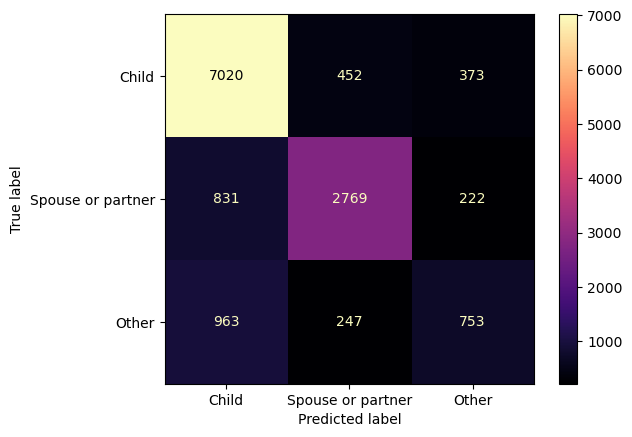

In [1262]:
y_pred = pred_post.prediction.swifter.apply(lambda x: convert_class(x)).to_numpy()
y_true = pred_post.label.swifter.apply(lambda x: convert_class(x)).to_numpy()
ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred,
                                        labels=['Child','Spouse or partner','Other'],
                                        cmap='magma')
plt.show()

Pandas Apply:   0%|          | 0/3683 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3683 [00:00<?, ?it/s]

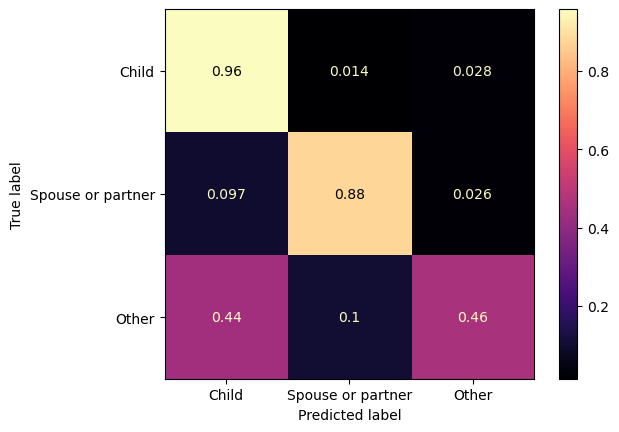

In [1263]:
y_pred = test_user.pred.swifter.apply(lambda x: convert_class(x)).to_numpy()
y_true = test_user.label.swifter.apply(lambda x: convert_class(x)).to_numpy()
ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred,
                                        labels=['Child','Spouse or partner','Other'],
                                        cmap='magma',
                                        normalize='true')
plt.show()

## Single Task

In [1264]:
pred_post = pd.read_csv('./multi-task-NLP-master/result/userclass_test_predictions_single_emb512_epoch10.tsv', sep='\t')

In [1265]:
pred_post = pred_post.sort_values('uid').set_index('uid')

In [1266]:
def person_pred(x):
    d = dict(x.prediction.apply(lambda x: relation_class(x)).value_counts())
    proba = [0, 0, 0]
    for k,v in d.items():
        proba[k] = v
    proba = proba / np.sum(proba)
    return proba

In [1267]:
pred_post['score'] = pred_post.score.swifter.apply(lambda x : np.array([float(s) for s in x[1:-1].split()]))

Pandas Apply:   0%|          | 0/13630 [00:00<?, ?it/s]

In [1268]:
pred_post['user'] = test_post.iloc[:,2]

In [1269]:
test_user = pred_post[['user','label']].drop_duplicates().reset_index(drop=True)

In [1270]:
test_user = test_user.join(pred_post.groupby('user').apply(lambda x : np.mean(np.stack(x.score.to_numpy(), axis=0), axis=0)).rename('probability'), on='user', how='left')

In [1271]:
test_user = test_user.join(pred_post.groupby('user').apply(lambda x : person_pred(x)).rename('proba'), on='user', how='left')

In [1272]:
test_user['pred'] = test_user.probability.swifter.apply(lambda x: np.argmax(x))

Pandas Apply:   0%|          | 0/3683 [00:00<?, ?it/s]

In [1273]:
test_user['label'].value_counts()

I am their child                2179
I am their partner or spouse     860
Other                            644
Name: label, dtype: int64

In [1274]:
ACC = []
PRECISION = []
RECALL = []
FSCORE = []
AUC = []

for train_index, test_index in sss.split(pred_post, pred_post['label']):
    test_post_split = pred_post.loc[test_index,:]
    y_pred = test_post_split.prediction.swifter.apply(lambda x: relation_class(x)).to_numpy()
    y_true = test_post_split.label.swifter.apply(lambda x: relation_class(x)).to_numpy()
    y_true_auc = pd.get_dummies(test_post_split.label.swifter.apply(lambda x: relation_class(x))).to_numpy()
    y_pred_auc = np.stack(test_post_split.score.to_numpy(), axis=0)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true_auc, y_pred_auc, average='weighted', multi_class='ovr')
    ACC.append(acc)
    PRECISION.append(precision)
    RECALL.append(recall)
    FSCORE.append(fscore)
    AUC.append(auc) 

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12267 [00:00<?, ?it/s]

In [1275]:
print('Accuracy : {0:.4f} ± {1:.4f}'.format(np.mean(ACC), np.std(ACC)))
print('Precision : {0:.4f} ± {1:.4f}'.format(np.mean(PRECISION), np.std(PRECISION)))
print('Recall : {0:.4f} ± {1:.4f}'.format(np.mean(RECALL), np.std(RECALL)))
print('Fscore : {0:.4f} ± {1:.4f}'.format(np.mean(FSCORE), np.std(FSCORE)))
print('ROCAUC : {0:.4f} ± {1:.4f}'.format(np.mean(AUC), np.std(AUC)))

Accuracy : 0.7739 ± 0.0015
Precision : 0.7646 ± 0.0017
Recall : 0.7739 ± 0.0015
Fscore : 0.7674 ± 0.0016
ROCAUC : 0.8858 ± 0.0010


In [1276]:
ACC = []
PRECISION = []
RECALL = []
FSCORE = []
AUC = []

for train_index, test_index in sss.split(test_user, test_user['label']):
    test_user_split = test_user.loc[test_index,:]
    y_pred = test_user_split.pred.to_numpy()
    y_true = test_user_split.label.swifter.apply(lambda x: relation_class(x)).to_numpy()
    y_true_auc = pd.get_dummies(test_user_split.label.swifter.apply(lambda x: relation_class(x))).to_numpy()
    y_pred_auc = np.stack(test_user_split.probability.to_numpy(), axis=0)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true_auc, y_pred_auc, average='weighted', multi_class='ovr')
    ACC.append(acc)
    PRECISION.append(precision)
    RECALL.append(recall)
    FSCORE.append(fscore)
    AUC.append(auc) 

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3315 [00:00<?, ?it/s]

In [1277]:
print('Accuracy : {0:.4f} ± {1:.4f}'.format(np.mean(ACC), np.std(ACC)))
print('Precision : {0:.4f} ± {1:.4f}'.format(np.mean(PRECISION), np.std(PRECISION)))
print('Recall : {0:.4f} ± {1:.4f}'.format(np.mean(RECALL), np.std(RECALL)))
print('Fscore : {0:.4f} ± {1:.4f}'.format(np.mean(FSCORE), np.std(FSCORE)))
print('ROCAUC : {0:.4f} ± {1:.4f}'.format(np.mean(AUC), np.std(AUC)))

Accuracy : 0.8588 ± 0.0014
Precision : 0.8536 ± 0.0016
Recall : 0.8588 ± 0.0014
Fscore : 0.8506 ± 0.0016
ROCAUC : 0.9240 ± 0.0016


Pandas Apply:   0%|          | 0/13630 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13630 [00:00<?, ?it/s]

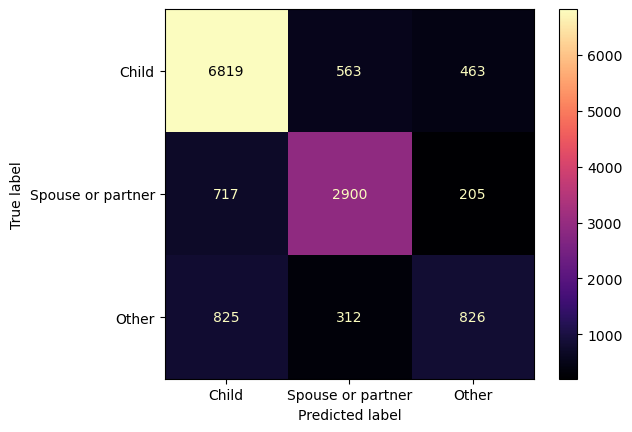

In [1278]:
y_pred = pred_post.prediction.swifter.apply(lambda x: convert_class(x)).to_numpy()
y_true = pred_post.label.swifter.apply(lambda x: convert_class(x)).to_numpy()
ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred,
                                        labels=['Child','Spouse or partner','Other'],
                                        cmap='magma')
plt.show()

Pandas Apply:   0%|          | 0/3683 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3683 [00:00<?, ?it/s]

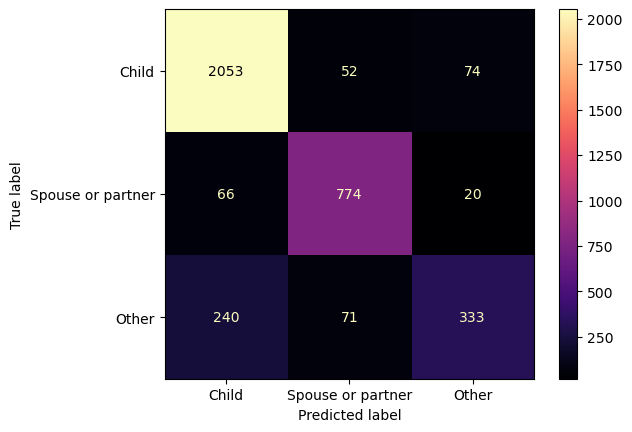

In [1279]:
y_pred = test_user.pred.swifter.apply(lambda x: convert_class(x)).to_numpy()
y_true = test_user.label.swifter.apply(lambda x: convert_class(x)).to_numpy()
ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred,
                                        labels=['Child','Spouse or partner','Other'],
                                        cmap='magma')
plt.show()

# Time

In [1171]:
pred_post = pd.read_csv('./multi-task-NLP-master/result/userclass_test_predictions_all.tsv', sep='\t')

In [1172]:
test_post = pd.read_csv('./multi-task-NLP-master/adrd/data/all_test_post.tsv', sep='\t', index_col=0)

In [1173]:
pred_post = pred_post.sort_values('uid').set_index('uid')

In [1174]:
pred_post = pred_post.join(test_post, how='left').reset_index(drop=True)

In [1175]:
pred_post['score'] = pred_post.score.swifter.apply(lambda x : np.array([float(s) for s in x[1:-1].split()]))

Pandas Apply:   0%|          | 0/85468 [00:00<?, ?it/s]

In [1176]:
pred_post['join_date'] = pd.to_datetime(pred_post.join_date).dt.date

In [1177]:
pred_post['post_date'] = pd.to_datetime(pred_post.post_date).dt.date

In [1178]:
pred_post['Active days'] = pred_post.swifter.apply(lambda x: (x.post_date - x.join_date), axis=1).dt.days

In [1179]:
partner_pred_post = pred_post[pred_post['label'] == 'I am their partner or spouse']

In [1180]:
partner_pred_post['Relationship'] = 'Spouse or partner'

C:\Users\Song_\AppData\Local\Temp\ipykernel_43216\953932196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partner_pred_post['Relationship'] = 'Spouse or partner'


In [1181]:
partner_pred_post['Predict probability of correct label'] = partner_pred_post.score.swifter.apply(lambda x: x[0])

Pandas Apply:   0%|          | 0/49752 [00:00<?, ?it/s]

C:\Users\Song_\AppData\Local\Temp\ipykernel_43216\374271076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partner_pred_post['Predict probability of correct label'] = partner_pred_post.score.swifter.apply(lambda x: x[0])


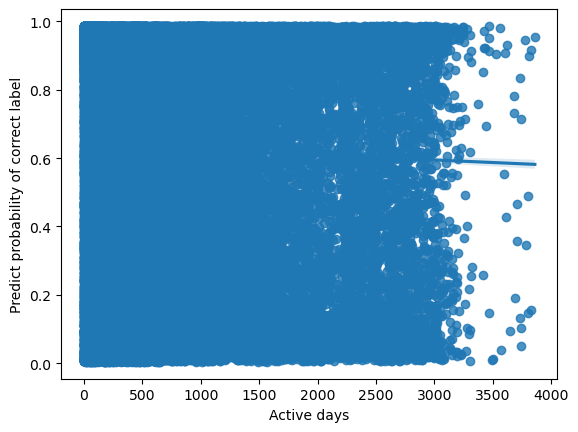

In [1137]:
sns.regplot(x='Active days', y='Predict probability of correct label', data=partner_pred_post)
plt.show()

In [1130]:
child_pred_post = pred_post[pred_post['label'] == 'I am their child']

In [1139]:
child_pred_post['Relationship'] = 'Child'

C:\Users\Song_\AppData\Local\Temp\ipykernel_43216\3105701590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child_pred_post['Relationship'] = 'Child'


In [1134]:
child_pred_post['Predict probability of correct label'] = child_pred_post.score.swifter.apply(lambda x: x[1])

Pandas Apply:   0%|          | 0/35716 [00:00<?, ?it/s]

C:\Users\Song_\AppData\Local\Temp\ipykernel_43216\35949854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child_pred_post['Predict probability of correct label'] = child_pred_post.score.swifter.apply(lambda x: x[1])


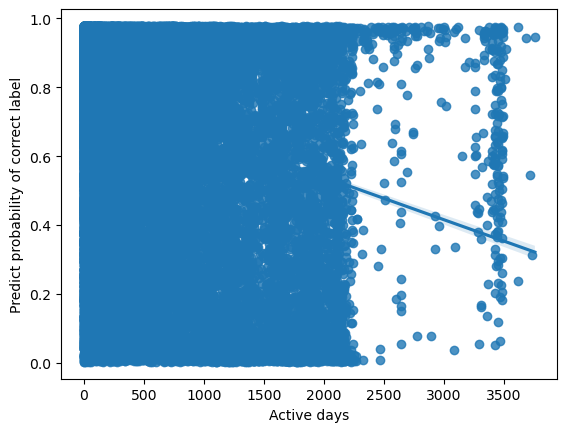

In [1135]:
sns.regplot(x='Active days', y='Predict probability of correct label', data=child_pred_post)
plt.show()